**Inference Notebook :** [ https://www.kaggle.com/virajkadam/plant-pathology-inference ]

# Resources
* **[ https://www.kaggle.com/ankursingh12/resized-plant2021 ]**
* **[ https://www.kaggle.com/arnabs007/apple-leaf-diseases-with-inceptionresnetv2-keras ]**

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
import pickle

#kfolds
from sklearn.model_selection import KFold 
from sklearn.preprocessing import MultiLabelBinarizer



import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications import EfficientNetB7,InceptionResNetV2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

from tensorflow_addons.metrics import F1Score

# Loading data.

In [2]:
train=pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
sample_sub=pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')

train_dir='../input/resized-plant2021/img_sz_256'
test_dir='../input/plant-pathology-2021-fgvc8/test_images'

sample_sub.head()

image   labels
0  85f8cb619c66b863.jpg  healthy
1  ad8770db05586b59.jpg  healthy
2  c7b03e718489f3ca.jpg  healthy

In [3]:
train.head()

image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex

**Basic EDA**

In [4]:
print(f'Number of Images in Training set : {len(os.listdir(train_dir))}')
print(f'Number of Images in test set : {len(os.listdir(test_dir))}')

Number of Images in Training set : 18632
Number of Images in test set : 3


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Label counts')

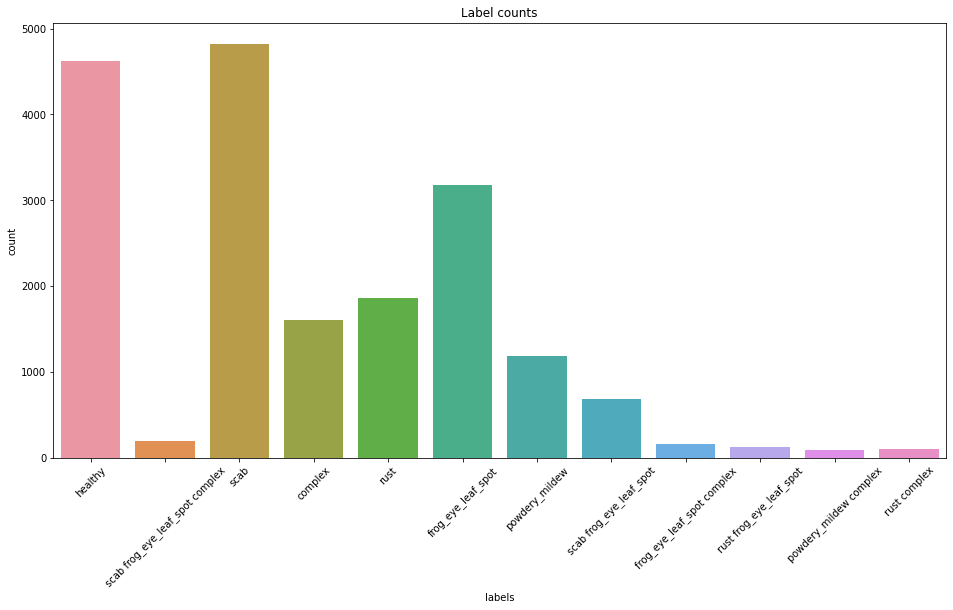

In [5]:
#lets count the instances of each class we have :

fig,ax=plt.subplots(figsize=(16,8))
sns.countplot(train['labels'])
#rotate labels
plt.setp(ax.get_xticklabels(),rotation=45)

plt.title('Label counts')


**Multilabel Classification**

In [6]:
#converting the labels as multiple labels:
train['labels']=train['labels'].str.split(' ')

mlb = MultiLabelBinarizer()

# one hot encode labels
lab=mlb.fit_transform(train['labels'])
lab[:10]

array([[0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [7]:
#classes for OHE encoded var.
classes=mlb.classes_
classes

array(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew',
       'rust', 'scab'], dtype=object)

**Lets see some Images**

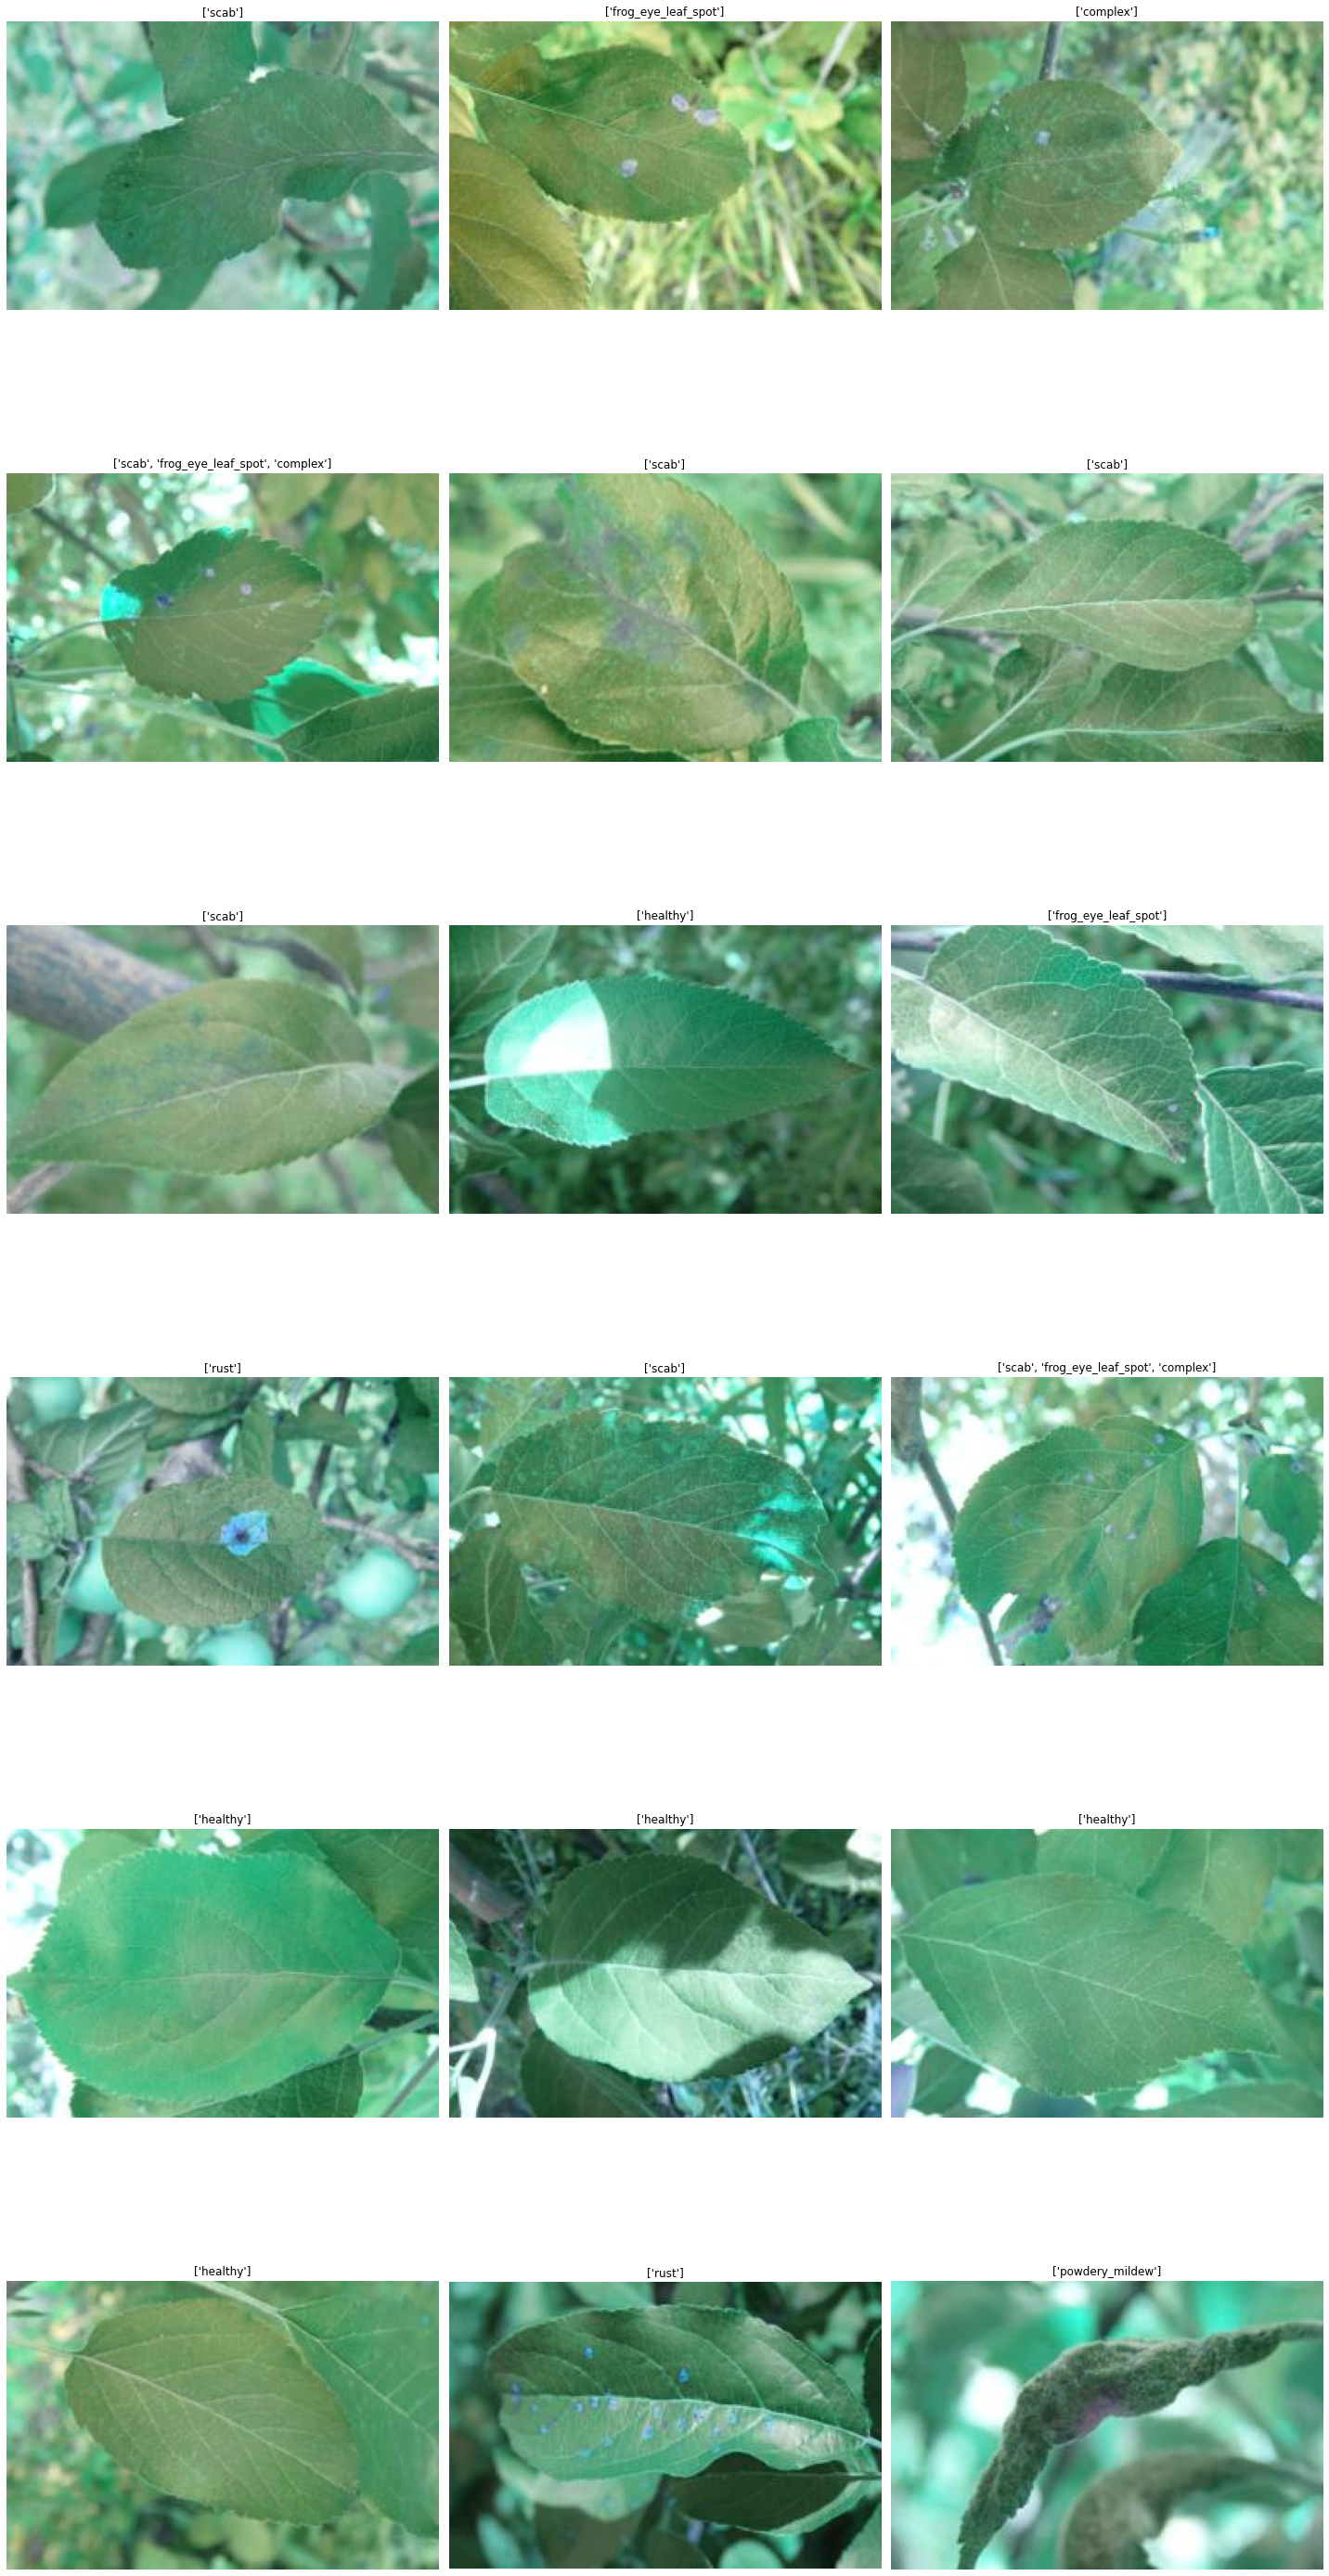

In [8]:
def show_sample_images(df,train_dir,n):
    dfs=df.sample(n)
    plt.subplots(int(n/3),3,figsize=(20,7*int(n/3)))
    
    for i in range(n):
        plt.subplot(int(n/3),3,i+1)
        
        row=dfs.iloc[i]
        img_id=row['image']
        title=row['labels']
        path=os.path.join(train_dir +'/' +f'{img_id}')
        image=cv2.imread(path)
        
        plt.imshow(image)
        plt.title(f'{title}')
        plt.axis('off')
     
    plt.grid('off')
    plt.tight_layout()
    plt.show()
show_sample_images(train,train_dir,n=18)

**SETTING RANDOM SEED**

In [9]:
#setting random seed :
seed=7

def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['PYHTONHASHSEED']=str(seed)
    
set_seed(seed)

* **USING ALREADY RESIZED IMAGES. CREDITS TO AUTHOR [ https://www.kaggle.com/ankursingh12/resized-plant2021 ]**

**Loading Images**

In [10]:
def load_images(df,val_df,path):
    
    datagen=ImageDataGenerator(
        width_shift_range=(0.1,0.2),
        height_shift_range=(0.1,0.2),
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        rescale=1./255
        )
    
    train=datagen.flow_from_dataframe(
        dataframe=df,
        directory = path,
        x_col='image',
        y_col='labels',
        target_size=image_size,
        batch_size=batch,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=True,
        seed=seed)
    
    val=datagen.flow_from_dataframe(
        dataframe=val_df,
        directory = path,
        x_col='image',
        y_col='labels',
        target_size=image_size,
        batch_size=batch,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=True,
        seed=seed)
    
    return train,val
    

In [11]:
#loading images:

batch=64
image_size=(256,256)

kf=KFold(n_splits = 3, random_state = seed, shuffle = True) 
num_images=len(train)
y=train.labels

# Model

In [12]:
def build_model(base,dense=False):
    '''build a cnn model with base provided.'''
    
    inp=layers.Input(shape=(256,256,3))
    
    x=base(inp)
    
    
    x=layers.GlobalAveragePooling2D()(x)
#     x=layers.BatchNormalization()(x)
    
    #dense
    if dense: 
        for i in range(len(dense)):
            x=layers.Dense(dense[i],activation='relu')(x)
#             x=layers.Dropout(rate=0.5)(x)
            x=layers.BatchNormalization()(x)
            
    #output
    out=layers.Dense(6,activation='sigmoid')(x)
    
    model=Model(inputs=inp,outputs=out)
    
    return model
            

In [13]:
#plotting accuracy and loss  
def plot_history(history):
    his=pd.DataFrame(history.history)
    plt.subplots(1,2,figsize=(16,8))
    
    #loss:
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['loss'],color='g',label='training')
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.legend()
    plt.title('Loss')
    
    #accuracy
    plt.subplot(1,2,2)
    plt.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
    plt.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
    
    #f1_score
    plt.plot(range(len(his)),his['f1_score'],color='steelblue',label='training_f1')
    plt.plot(range(len(his)),his['val_f1_score'],color='maroon',label='validation_f1')
    
    plt.legend()
    plt.title('accuracy')
    
    plt.show()              

# Model1 with EfficientNet B7 Base

In [14]:
#using inceptionresnet for transfer learning
base1=InceptionResNetV2(include_top=False,weights='imagenet')

219062272/219055592 [==============================] - 1s 0us/step


In [15]:
#metrics for model evaluation:
f1_score=F1Score(num_classes=6,average='macro',name='f1_score')

#model name for training in folds
def get_model_name(i):
    '''return model name for out of folds'''
    return f'model_{i}.h5' 

# Training model in folds

Found 12421 validated image filenames belonging to 6 classes.
Found 6211 validated image filenames belonging to 6 classes.
Epoch 1/30
194/194 [==============================] - 362s 2s/step - loss: 0.4573 - accuracy: 0.3077 - f1_score: 0.2393 - val_loss: 0.3757 - val_accuracy: 0.4864 - val_f1_score: 0.4384

Epoch 00001: val_f1_score improved from -inf to 0.43843, saving model to model_0.h5
Epoch 2/30
194/194 [==============================] - 275s 1s/step - loss: 0.3652 - accuracy: 0.4986 - f1_score: 0.4521 - val_loss: 0.3531 - val_accuracy: 0.5355 - val_f1_score: 0.4960

Epoch 00002: val_f1_score improved from 0.43843 to 0.49602, saving model to model_0.h5
Epoch 3/30
194/194 [==============================] - 273s 1s/step - loss: 0.3419 - accuracy: 0.5406 - f1_score: 0.5021 - val_loss: 0.3359 - val_accuracy: 0.5408 - val_f1_score: 0.4998

Epoch 00003: val_f1_score improved from 0.49602 to 0.49984, saving model to model_0.h5
Epoch 4/30
194/194 [==============================] - 274s 1s

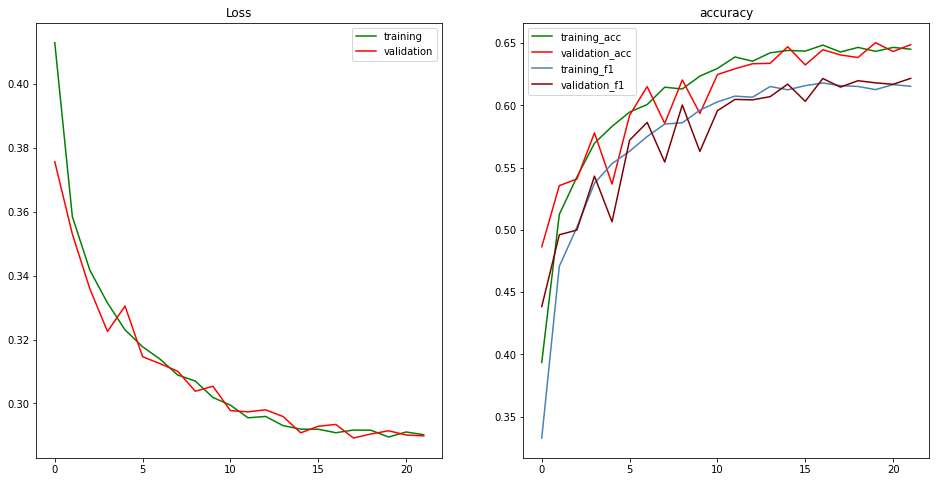

Number of folds Trained 1
Found 12421 validated image filenames belonging to 6 classes.
Found 6211 validated image filenames belonging to 6 classes.
Epoch 1/30
194/194 [==============================] - 289s 1s/step - loss: 0.4549 - accuracy: 0.3191 - f1_score: 0.4733 - val_loss: 0.3646 - val_accuracy: 0.4898 - val_f1_score: 0.4348

Epoch 00001: val_f1_score improved from -inf to 0.43482, saving model to model_1.h5
Epoch 2/30
194/194 [==============================] - 274s 1s/step - loss: 0.3628 - accuracy: 0.4926 - f1_score: 0.4586 - val_loss: 0.3462 - val_accuracy: 0.5194 - val_f1_score: 0.4731

Epoch 00002: val_f1_score improved from 0.43482 to 0.47305, saving model to model_1.h5
Epoch 3/30
194/194 [==============================] - 282s 1s/step - loss: 0.3419 - accuracy: 0.5418 - f1_score: 0.5222 - val_loss: 0.3337 - val_accuracy: 0.5672 - val_f1_score: 0.5321

Epoch 00003: val_f1_score improved from 0.47305 to 0.53209, saving model to model_1.h5
Epoch 4/30
194/194 [===============

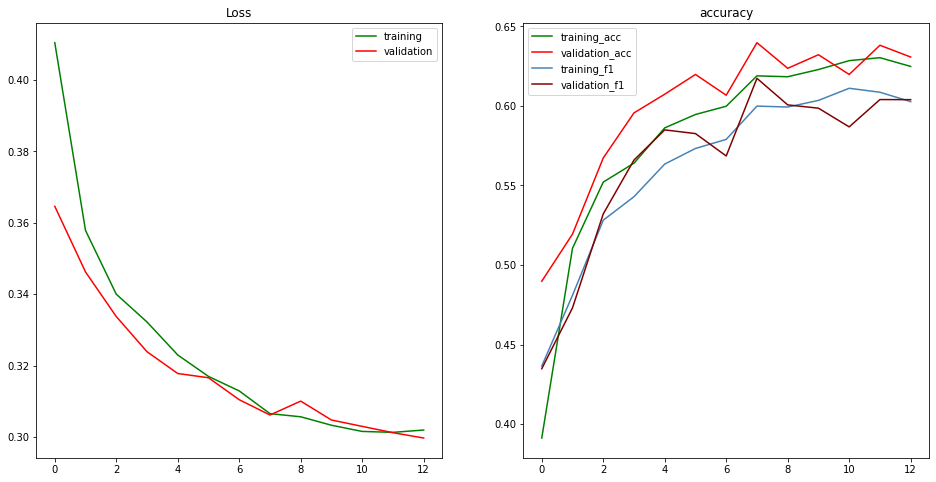

Number of folds Trained 2
Found 12422 validated image filenames belonging to 6 classes.
Found 6210 validated image filenames belonging to 6 classes.
Epoch 1/30
194/194 [==============================] - 291s 1s/step - loss: 0.4598 - accuracy: 0.3270 - f1_score: 0.4663 - val_loss: 0.3687 - val_accuracy: 0.4882 - val_f1_score: 0.4402

Epoch 00001: val_f1_score improved from -inf to 0.44020, saving model to model_2.h5
Epoch 2/30
194/194 [==============================] - 277s 1s/step - loss: 0.3621 - accuracy: 0.5024 - f1_score: 0.4532 - val_loss: 0.3491 - val_accuracy: 0.5198 - val_f1_score: 0.4768

Epoch 00002: val_f1_score improved from 0.44020 to 0.47680, saving model to model_2.h5
Epoch 3/30
194/194 [==============================] - 277s 1s/step - loss: 0.3414 - accuracy: 0.5505 - f1_score: 0.5111 - val_loss: 0.3346 - val_accuracy: 0.5639 - val_f1_score: 0.5414

Epoch 00003: val_f1_score improved from 0.47680 to 0.54145, saving model to model_2.h5
Epoch 4/30
194/194 [===============

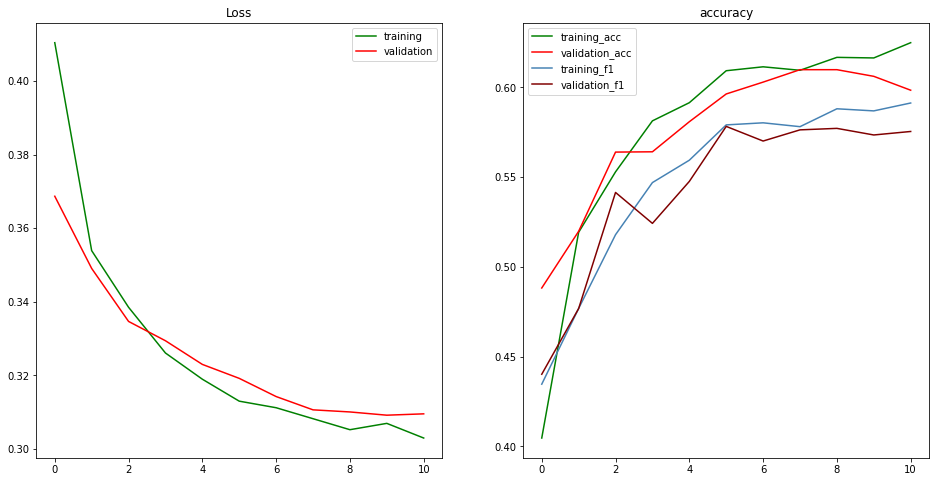

Number of folds Trained 3


In [16]:
i=0
for train_index,test_index in kf.split(train):
    train_set=train.iloc[train_index]
    val_set=train.iloc[test_index]
    
    train_gen,val_gen=load_images(train_set,val_set,train_dir)
    
    #model
    model=build_model(base=base1,dense=None)
    
    #freezing layers
    for layer in model.layers[:-1]:
        layer.trainable=False
    
    #compile
    model.compile(loss=BinaryCrossentropy(),
             optimizer='adam',
             metrics=['accuracy',f1_score])
    
    
    
    EPOCHS=30
    #callbacks:
    model_path=get_model_name(i)
    
    #reduce_lr
    reduce_lr=ReduceLROnPlateau(patience=2,factor=0.5,min_delta=1e-2,
                                monitor='val_f1_score',verbose=0,mode='max')

    #early stopping
    early_stopping=EarlyStopping(patience=5,min_delta=1e-3,
                              monitor='val_f1_score',restore_best_weights=True,mode='max')

    #save model:
    checkpoint1 = ModelCheckpoint(filepath=model_path, monitor='val_f1_score', verbose=1,
                                save_best_only=True,mode='max') 

    callbacks_1=[reduce_lr,checkpoint1,early_stopping]
    
    
    history1=model.fit(
        train_gen,
        validation_data=val_gen,
        steps_per_epoch=train_gen.n//batch,
        shuffle=True,
        callbacks=callbacks_1,
        epochs=EPOCHS,
        verbose=1
       )

    plot_history(history1)
    
    
    #clearing model 
    K.clear_session()
    
    #next fold:
    print('Number of folds Trained {}'.format(i+1))
    i+=1